## 0. Carga de librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from math import log
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.collections import LineCollection

# 1. Modelo determinista

Si ahora suponemos que $K_v$ es finito, tenemos las siguientes ecuaciones diferenciales acopladas:
$$
\begin{align} 
\frac{dV(\vec{x}, t)}{dt} &= r_v V(\vec{x}, t) \left[ 1 - \frac{V(\vec{x}, t)}{K_v} -\lambda_{vp}\frac{P(\vec{x}, t)}{K_v} \right] , \\
\frac{dP(\vec{x}, t)}{dt} &= -|r_p| P(\vec{x}, t)   \left[ 1 -\lambda_{pv}\frac{V(\vec{x}, t)}{K_v} \right] .
\end{align}
$$
Ahora tenemos dos ecuaciones diferenciales acopladas. Las definimos

In [3]:
def sistema(t, V, P, rv, rp, lambda_pv, lambda_vp, Kv):
    x = V
    y = P
    dx_dt = x*(rv*(1-x/Kv-lambda_vp*y/Kv))
    dy_dt = y*(-abs(rp)*(1-lambda_pv*x/Kv))
    return np.array([dx_dt, dy_dt])

## 1.1. Evolución temporal

## 1.2. Representación del espacio de fases

## 1.3. Cálculo de los exponentes de Lyapunov

También tenemos que hallar el Jacobiano del sistema, que es simplemente las derivadas de primer orden:
$$
J = 
\begin{pmatrix}
r_v\left( 1- \frac{2V}{K_v}-\lambda_{vp}\frac{P}{K_v}\right) & -\lambda_{vp}\frac{r_v V}{K_v} \\
|r_p|\lambda_{pv}\frac{P}{K_v} & -|r_p|\left( 1-\lambda_{pv}\frac{V}{K_v} \right)
\end{pmatrix}
$$

In [4]:
def jacobiano(V, P, rv, rp, lambda_pv, lambda_vp, Kv):
    J = np.array([
        [rv*(1-2*V/Kv-lambda_vp*P/Kv), -lambda_vp*rv*V/Kv],
        [abs(rp)*lambda_pv*P/Kv, -abs(rp)*(1-lambda_pv*V/Kv)]
    ])
    return J

Ahora podemos definir las ecuaciones de variación lineal, definidas como
$$
\dot \vec \Phi = D_xF(x)\cdot \vec\Phi,
$$
donde $J(t)$ es nuestro Jacobiano en función del tiempo, y $\delta x$ es la matriz que contiene las perturbaciones que le vamos a aplicar al sistema. Claramente, $x$ es cualquiera de las dos variables de nuestro sistema $V,\ P$.

Creamos un sistema extendido que incluya estas perturbaciones, de forma que tendremos 
$$
\begin{bmatrix}
\dot x \\
\dot \vec \Phi
\end{bmatrix}

 =
 
\begin{bmatrix}
F( x) \\
D_x F(x)\cdot \vec\Phi
\end{bmatrix}

$$

Además, por la regla de la cadena tenemos
$$
D_x f^t(x_0) = J[f^{t-1}(x_0)] ... J[f(x_0)] J(x_0)
$$

In [5]:
def sistema_extendido(t, Z, rv, rp, lambda_pv, lambda_vp, Kv):
    # Z es nuestra matriz con el sistema y las perturbaciones
    # extraemos nuestro sistema inicial
    V, P = Z[:2]
    
    # evolución del sistema original
    dV_dt, dP_dt = sistema(t, V, P, rv, rp, lambda_pv, lambda_vp, Kv)
    
    # hallamos el jacobiano
    J = jacobiano(V, P, rv, rp, lambda_pv, lambda_vp, Kv)
    
    # extraemos las variaciones
    delta = Z[2:].reshape((2,2))   # nos da una matriz 2x2
    
    # ecuaciones de variación lineal
    d_delta_dt = J @ delta # producto matricial
    
    # unimos las derivadas originales y de las variaciones
    dZ_dt = np.concatenate(([dV_dt, dP_dt], d_delta_dt.flatten()))
    
    return dZ_dt

### Resolución en tiempo discreto

Ahora resolvemos el sistema extendido. Definimos condiciones iniciales en las variables originales, y en las perturbaciones. Usaremos 
$$
\begin{bmatrix}
\dot x(t_0) \\
\dot \vec \Phi(t_0)
\end{bmatrix}

 =
 
\begin{bmatrix}
x_0 \\
\mathbb{I}
\end{bmatrix}

$$

In [6]:
# condiciones iniciales y parámetros
V0 = .1  
P0 = .01  
rv = 1
rp = 0.1 
lambda_pv = 0.044 
lambda_vp = 0.044 
Kv = 1

delta0 = np.eye(2).flatten() # usamos matriz identidad aplanada (base canónica)

# vector de condidiones iniciales extendidas
Z0 = np.concatenate(([V0, P0], delta0))

# definimos un intervalo de tiempo
t_span = (0,1000)
t_eval = np.linspace(t_span[0],t_span[1], 10000)

# resolvemos el sistema extendido
sol = solve_ivp(sistema_extendido, t_span, Z0, t_eval = t_eval, args = (rv, rp, lambda_pv, lambda_vp, Kv))

# extraemos las soluciones
V_sol = sol.y[0]
P_sol = sol.y[1]
delta_sol = sol.y[2:].reshape((2, 2, -1))

Con esto podemos hacer varias gráficas para ver cómo se comporta el sistema de forma más visual:


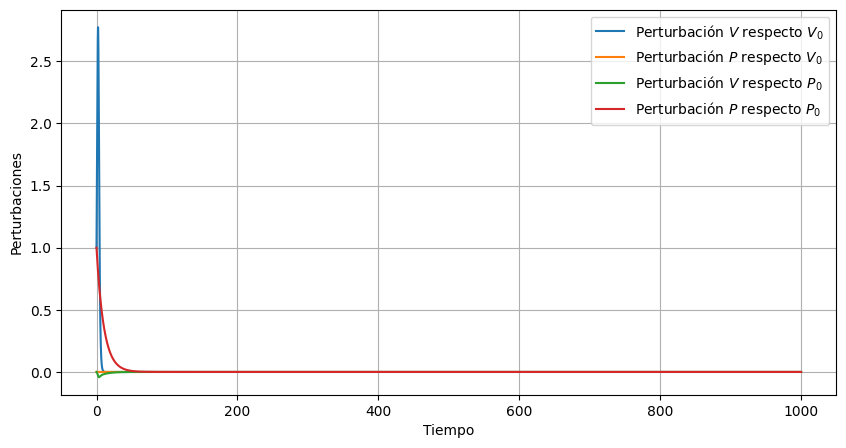

In [7]:
# 1. Evolución temporal de las perturbaciones
plt.figure(figsize=(10, 5))
plt.plot(sol.t, delta_sol[0, 0], label="Perturbación $V$ respecto $V_0$")
plt.plot(sol.t, delta_sol[1, 0], label="Perturbación $P$ respecto $V_0$")
plt.plot(sol.t, delta_sol[0, 1], label="Perturbación $V$ respecto $P_0$")
plt.plot(sol.t, delta_sol[1, 1], label="Perturbación $P$ respecto $P_0$")
plt.legend()
plt.xlabel("Tiempo")
plt.ylabel("Perturbaciones")
plt.grid()
plt.show()

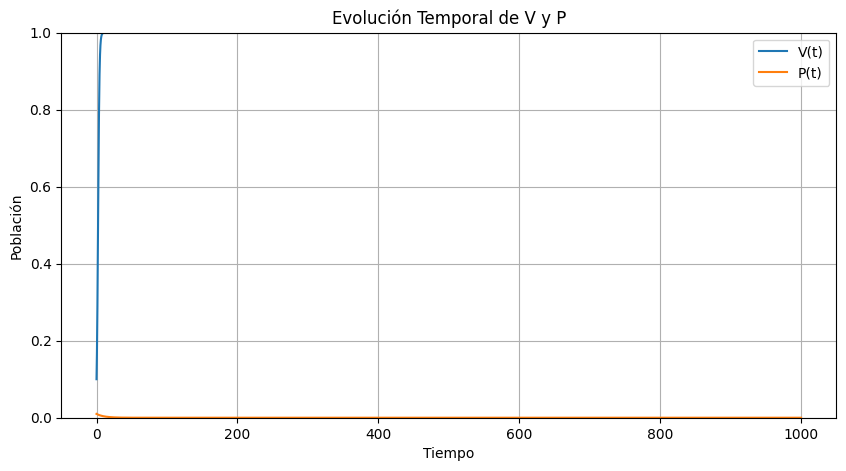

In [8]:
# 2. Evolución temporal de V(t) y P(t)
plt.figure(figsize=(10, 5))
plt.plot(sol.t, V_sol, label='V(t)')
plt.plot(sol.t, P_sol, label='P(t)')
plt.xlabel('Tiempo')
plt.ylabel('Población')
plt.title('Evolución Temporal de V y P')
plt.ylim([0,1])
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 3. Espacio de fases
plt.figure(figsize=(10, 5))
plt.plot(P_sol, V_sol)
plt.xlabel('P')
plt.ylabel('V')
plt.title('Espacio de fases del sistema')
plt.grid()
plt.show()

### Cálculo importante


Con el sistema extendido resulto, podemos calcular los exponentes característicos de Lyapunov (LCEs). Esto es, básicamente, hallar el crecimiento exponencial promedio de las perturbaciones a lo largo del tiempo. El LCE de orden $p$ se calcula como 
$$
\lambda_p = \lim_{k\to\infty} \frac{1}{kT}\sum_{i=1}^k \ln\| w_p^i \|.
$$

Para cada iteración, tenemos que hallar el Jacobiano $$J_k^* = J[f^{k-1}(x_0)]Q_{k-1},\quad k=2,3, ..., t, $$
donde $k$ es la iteración y $Q$ es la matriz ortogonal asociada al Jacobiano, $J_k = Q_k R_k$.
De esta forma, tenemos $$D_x f^t(x_0) = Q_t R_t ... R_1.$$

Finalmente, podemos hallar los LCEs con los valores diagonales $(\nu_{ii}^t)$ de $R_t$: 
$$\lambda_i = \lim_{t\to\infty} \frac1t \ln |\nu_{ii}^t|,$$
donde $(\nu_{ii}^t)$ son los elementos diagonales de la matriz producto $\Gamma^{(t)} = R_t ... R_1.$

In [9]:
# para guardar los exponentes
LCEs = np.zeros(2)
LCE_convergence = []  # para representarlos

# definimos un paso de reescalado
reeval = 1 # no son muchos pasos, asi que podemos afinar a uno
delta0 = np.eye(2)

# iteramos sobre el tiempo evaluado para propagar las perturbaciones
delta_matrices = []

for i in range(len(t_eval)-1):
    # estado actual del sistema
    V = V_sol[i]
    P = P_sol[i]
    
    # hallamos jacobiano evaluado en los V, P
    J = jacobiano(V, P, rv, rp, lambda_pv, lambda_vp, Kv)
    
    # propagamos la matriz delta con la ecuación de variación lineal
    delta0 = J @ delta0 * (t_eval[i+1] - t_eval[i]) + delta0
    
    # normalización y ortogonalización de los vectores de perturbación
    if (i+1) % reeval == 0:
        # ortogonalizacimos con Gram-Schmidt
        Q, R = np.linalg.qr(delta0)
        
        # actualizamos la matriz de perturbación con la ortogonalizada
        delta0 = Q
        
        # actualizamos los LCE sumando el log de las normas (diag de R)
        LCEs += np.log(np.abs(np.diag(R)))
        
        LCE_current = LCEs / ((i + 1) / reeval)
        LCE_convergence.append(LCE_current)
    delta_matrices.append(delta0.copy()) 
    
# hacemos el promedio temporal
LCEs /= t_eval[-1]

print("Exponentes de Lyapunov: ", LCEs)

Exponentes de Lyapunov:  [-0.10377515 -1.04100757]


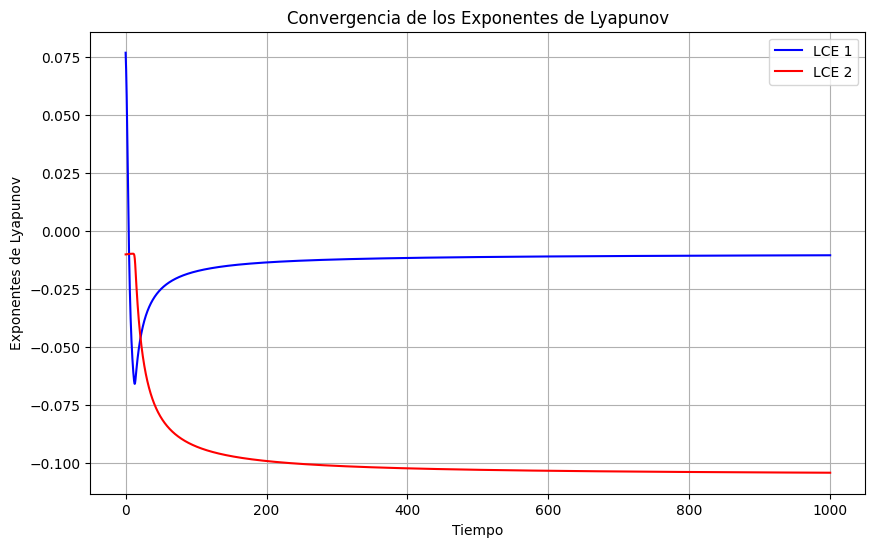

In [10]:
# Convertir lce_convergence en un array de numpy para graficarlo
LCE_convergence = np.array(LCE_convergence)

### GRAFICAR LA CONVERGENCIA DE LOS LCEs ###
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(LCE_convergence)) * reeval * (t_eval[1] - t_eval[0]), LCE_convergence[:, 0], label='LCE 1', color='b')
plt.plot(np.arange(len(LCE_convergence)) * reeval * (t_eval[1] - t_eval[0]), LCE_convergence[:, 1], label='LCE 2', color='r')
plt.xlabel('Tiempo')
plt.ylabel('Exponentes de Lyapunov')
plt.title('Convergencia de los Exponentes de Lyapunov')
plt.legend()
plt.grid()
plt.show()

Los LCEs nos dan información sobre la sensibilidad a las condiciones iniciales y sobre el comportamiento del propio sistema. En nuestro caso, 
- Los LCE suman negativo, lo que implica que el sistema es disipativo.
- Como todos son negativos, no hay evidencia de que sea un sistema caótico.
- Parece que hay atracción hacia un equilibrio (un punto fijo o un foco). 

---
# 2. Modelo estocástico

Ahora, después de aplicar el método de Euler-Maruyama, tenemos las discretizaciones de ambas ecuaciones, que son:
$$
\begin{align}
x_1^{(n+1)} = x_1 ^{(n)}+r_1 x_1^{(n)}\left( 1-\frac{x_1^{(n)}}{K_v}-\lambda_{12}\frac{x_2^{(n)}}{K_v} \right)\Delta t+ \sigma_1 x_1^{(n)}\sqrt{\Delta t} \zeta_1^{(n)}, \\
x_2^{(n+1)} = x_2^{(n)} -|r_2|x_2^{(n)}\left( 1-\lambda_{21}\frac{x_1^{(n)}}{K_v} \right) \Delta t +\sigma_2 x_2^{(n)}\sqrt{\Delta t} \zeta_2^{(n)}.
\end{align} 
$$

In [13]:
def euler_maruyama(model, x0, t_span, dt, r, a, Kv, sigma):
    """
    Euler maruyama method
    :param system:  función definida antes
    :param x0: condición inicial (array de len N)
    :param t0: tiempo inicial (float)
    :param t_max: tiempo final (float)
    :param dt: step del tiempo (float)
    :param r: array con r_i
    :param a: matriz con a_ij
    :param sigma: array con sigma_i
    :return: (t_vals, x_vals), con x_vals un array (num_steps+1, N)
    """
    
# V0 = .1  
# P0 = .01  
# rv = 1
# rp = 0.1 
# lambda_pv = 0.044 
# lambda_vp = 0.044 
# Kv = 1
    # definimos algunos parámetros
    np.random.seed(2) # para reproducibilidad
    N=len(x0) # en nuestro caso será 4
    t0 = t_span[0]
    t_max = t_span[-1]
    num_steps = int((t_max-t0)/dt)
    lambda12 = a[1,2]
    lambda21 = a[2,1]
    
    # guardamos los valores 
    t_vals = np.linspace(t0, t_max, num_steps+1)
    x_vals = np.zeros((num_steps+1,N))
    
    x_vals[0, :] = x0
    x = x0.copy()
    
    for n in range(num_steps): # para cada paso temporal
        t = t_vals[n]
        
        # parte determinista
        F = model(t,x,r,a) # también array de 4

        # vector del ruido
        
        for i in range(N): # para cada especie
            # introducimos la variable aletoria
            zetta = np.random.normal(0, 1)
            
            # hallamos el siguiente valor
            x[i] = x[i]+ F[i]*dt + sigma[i]*x[i]*np.sqrt(dt)*zetta
            
            # si baja del umbral, suponemos que se extingue
            if x[i] <= 1e-10:
                x[i] = 0
                
            x_vals[n+1,i] = x[i]    
    return t_vals, x_vals

## 2.1. Evolución temporal
Ahora lo aplicamos para obtener su evolución con el tiempo.

In [ ]:
# primero definimos algunas variables necesarias


In [ ]:
# aplicamos la función de Euler-Maruyama
t_vals, x_vals = euler_maruyama()

## 2.2. Representación del espacio de fases


## 2.3. Cálculo de los exponentes de Lyapunov